Notebook commun pour le projet


Groupe Emission:

In [58]:
import numpy as np 
import matplotlib.pyplot as plt
import numba as nb
import cython as cy
import scipy
import const


In [12]:
"""
gamma_chapeau_prime = 1 #TODO : Find the value of gamma_chapeau_prime
sigma_T = (8 *const.pi / 3 ) *  const.physical_constants['classical electron radius'][0]**2
P_prime = 1 
e_prime_i = P_prime / (gamma_chapeau_prime - 1) 
def B_prime(epsilon_B):
    return np.sqrt(8 * const.pi * epsilon_B * e_prime_i) #TODO : Find e_prime_i
beta_d = 1 #TODO : Find the value of beta_d

def K1(x) :
    return scipy.special.kn(1, x)

def K2(x) :
    return scipy.special.kn(2, x)

def K3(x) :
    return scipy.special.kn(3, x)

## constantes de scipy 
mp = scipy.constants.m_p
c = scipy.constants.c
kB = scipy.constants.k
epsilon_e = 0.1
## constantes du sujet 
T_prime = 10**14 # en Kelvin bien sûr 

zeta = mp * c**2/(kB*T_prime)
gamma_maj = K3(zeta) /K2(zeta) - 1/zeta
def gamma_prime_c(epsilon_B, t):
    return (3 * const.electron_mass * const.c * gamma_maj) / (4 * sigma_T * epsilon_B * e_prime_i * t) #TODO : t ???

gamma_prime_m = max(1, (p - 2) / (p - 1) * const.proton_mass / const.electron_mass * epsilon_e *(gamma_maj -1))


def n_prime(no):
    return no * ((gamma_chapeau_prime * gamma_maj +1)/ (gamma_chapeau_prime -1))


def n_prime_R(no): 
    return n_prime(no) * min(1, (p - 2) / (p - 1) * const.proton_mass / const.electron_mass * epsilon_e *(gamma_maj -1))

def epsilon_prime_nu_prime_p(p, epsilon_B, no):
    return 0.88 * 256 / 27 * (p - 1) / (3*p -1) * const.elementary_charge**3 / (const.electron_mass * const.c**2) * n_prime_R(no) * B_prime(epsilon_B)
TODO : #verify "elementary charge"

def nu_prime_m(epsilon_B):
    return 3/16 * gamma_prime_m**2 * const.elementary_charge * B_prime(epsilon_B) / (const.electron_mass * const.c)

def nu_prime_c(epsilon_B, t):
    return 3/16 * gamma_prime_c(epsilon_B, t)**2 * const.elementary_charge * B_prime(epsilon_B) / (const.electron_mass * const.c)



def epsilon_prime_nu_prime(epsilon_B, no, t, p, nu_prime):
    if nu_prime_m <= nu_prime_c: 
        return epsilon_prime_nu_prime_p(p, epsilon_B, no) * choix_1(nu_prime, nu_prime_m(epsilon_B), nu_prime_c(epsilon_B, t), p)
    else:
        return epsilon_prime_nu_prime_p(p, epsilon_B, no) * choix_2(nu_prime, nu_prime_c(epsilon_B, t), nu_prime_m(epsilon_B), p)
        """

SyntaxError: invalid syntax (2014495165.py, line 43)

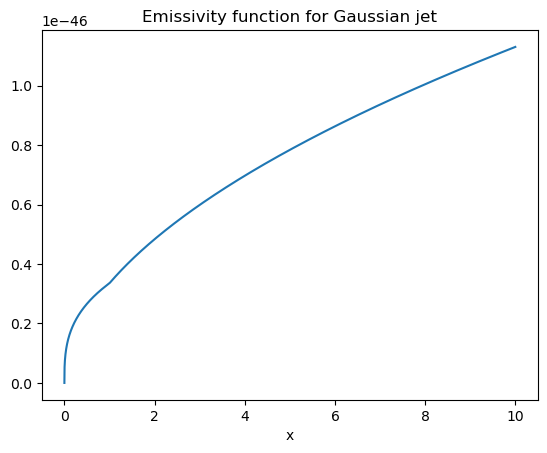

In [38]:
#Première approximation auxiliaire de la fonction liée à l'émission (on fixera la valeur de gamma dans notre cas, 
#celle-ci se calcule à l'aide des différentes fonctions de Bessel
#On peut se donner une "constante" kappa qui est nuprimec/nuprimem
#Les paramètres que l'on a fixé : p; gamma_chapeau_prime; gamma_maj; 
"""
n0 = 1/np.power(10,3)
epsilon_e = 0.14
epsi_b_gaussianJ = 2.44*(1/np.power(10,4))
epsi_b_hollow_coneJ = 4.12*(1/np.power(10,5))
epsi_b_SpindleJ = 6.60*(1/np.power(10,4))
p = 2.05

gamma_chapeau_prime = 2
sigma_T = (8 *const.pi / 3 ) *  const.physical_constants['classical electron radius'][0]**2

P_prime = 1 
e_prime_i = P_prime / (gamma_chapeau_prime - 1) 
gamma_maj = 2

def n_prime(no):
    return no * ((gamma_chapeau_prime * gamma_maj +1)/ (gamma_chapeau_prime -1))
def power_I(x,y):
    return 1/np.power(x,y)
def B_prime(epsilon_B):
    return np.sqrt(8 * const.pi * epsilon_B * e_prime_i)
def epsilon_prime_nu_prime_p(p, epsilon_B, no):
    return 0.88 * 256 / 27 * (p - 1) / (3*p -1) * const.elementary_charge**3 / (const.electron_mass * const.c**2) * n_prime_R(no) * B_prime(epsilon_B)
                                                                                                                                                                                                                                    
#On nomralise les fonctions, on prend en plus p = 2

def gamma_prime_m(p):
    return np.maximum(1, (p - 2) / (p - 1) * const.proton_mass / const.electron_mass * epsilon_e *(gamma_maj -1))

def gamma_prime_c(epsilon_B, t):
    return (3 * const.electron_mass * const.c * gamma_maj) / (4 * sigma_T * epsilon_B * e_prime_i * t)

def n_prime_R(no): 
    return n_prime(no) * min(1, (p - 2) / (p - 1) * const.proton_mass / const.electron_mass * epsilon_e *(gamma_maj -1))
def nu_prime_m(epsilon_B):
    return 3/16 * gamma_prime_m(p)**2 * const.elementary_charge * B_prime(epsilon_B) / (const.electron_mass * const.c)
def nu_prime_c(epsilon_B, t):
    return 3/16 * gamma_prime_c(epsilon_B, t)**2 * const.elementary_charge * B_prime(epsilon_B) / (const.electron_mass * const.c)

def Kappa(epsilon_B,t):
    return nu_prime_c(epsilon_B,t)/nu_prime_m(epsilon_B)

def SlowcEmission(x,Kappa,p,epsilon_B,no,t):
    if x < 1:
        return np.power(x,1/3)*epsilon_prime_nu_prime_p(p,epsilon_B,no)
    elif x>=1 and x < Kappa(epsilon_B,t):
        return epsilon_prime_nu_prime_p(p,epsilon_B,no)*power_I(x,-(p-1)/2)
    else:
        return power_I(Kappa(epsilon_B,t),-1/2)*power_I(-p/2)*epsilon_prime_nu_prime_p(p,epsilon_B,no)
    
def FastcEmission(x, Kappa,p,epsilon_B,no,t):
    if x > Kappa(epsilon_B,t):
        return epsilon_prime_nu_prime_p(p,epsilon_B,no)*np.power(Kappa(epsilon_B,t),-1/3)*np.power(x,1/3)
    elif x >= Kappa(epsilon_B,t) and x <1:
        return epsilon_prime_nu_prime_p(p,epsilon_B,no)*np.power(Kappa(epsilon_B,t),1/2)*power_I(x,-1/2)
    else:
        epsilon_prime_nu_prime_p(p,epsilon_B,no)*power_I(Kappa(epsilon_B,t),-1/2)*power_I(x,-p/2)
        

t = 10


SlowcEmission_vect = np.vectorize(lambda x: SlowcEmission(x,Kappa,p,epsi_b_gaussianJ,n0,t))
FastcEmission_vect = np.vectorize(lambda x: FastcEmission(x, Kappa,p,epsi_b_gaussianJ,n0,t))
def Emission_function(Kappa,x,no,p,epsilon_B,t):
    if Kappa(epsilon_B,t) > 1:
        return SlowcEmission_vect(x)
    else:
        return FastcEmission_vect(x)
x = np.linspace(0,10,5000)

y_g = Emission_function(Kappa,x,n0,p,epsi_b_gaussianJ,t)
plt.plot(x,y_g)
plt.title("Emissivity function for Gaussian jet")
plt.xlabel("x")
plt.show()

    """
                                                                                                    


Retour point par point sur les différentes fonctions définies et vérification de leur cohérence:


Définition du paramètre $\Gamma$ avec les fonctions de Bessel et $\xi$

On a d'après l'équation (12):
$$ \Gamma = \frac{K_{3}(\xi)}{K_{2}(\xi)} - \frac{1}{\xi}    $$
Sachant que par analyse dimensionnelle $\xi$ est sans unité

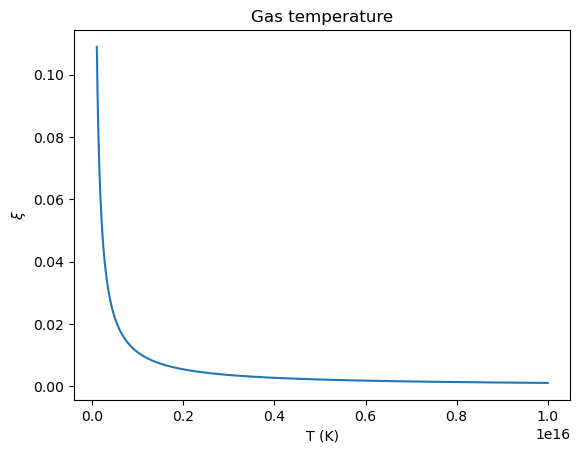

In [52]:
#Définition de Xi:
def xi(T):
    return (const.m_p*scipy.constants.c**2)/(const.k_b*T)

T = np.linspace(10**14,10**16,10000)
res = xi(T)
plt.plot(T,xi(T))
plt.title("Gas temperature")
plt.xlabel("T (K)")
plt.ylabel(r"$\xi $")
plt.show()



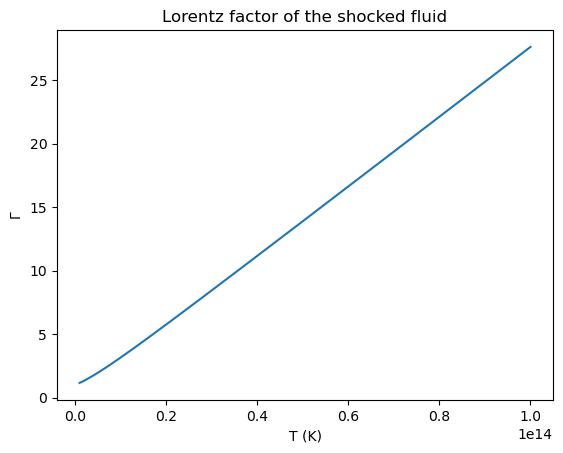

In [50]:
#Définition des fonctions de Bessel de première espèce (avec une limite finie en 0)
def K1(T) :
    return scipy.special.kn(1, xi(T))

def K2(x) :
    return scipy.special.kn(2, xi(T))

def K3(x) :
    return scipy.special.kn(3, xi(T))
def gamma_maj(T):
    return (K3(xi(T))/K2(xi(T)) - 1/xi(T))

plt.plot(T,gamma_maj(T))
plt.title("Lorentz factor of the shocked fluid")
plt.xlabel("T (K)")
plt.ylabel(r"$\Gamma $")
plt.show()



On définit maintenant la fonction $\hat{\gamma}'$:

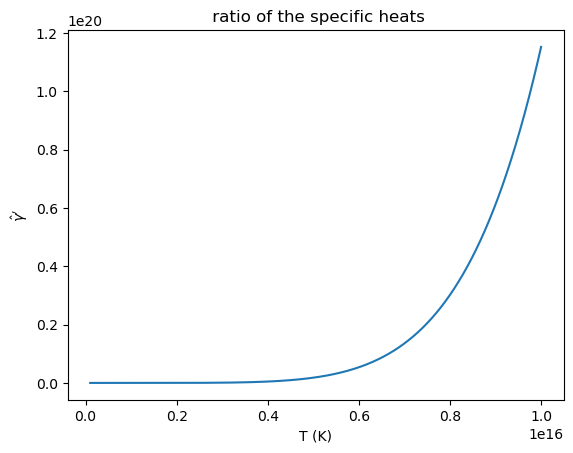

In [54]:
def gamma_chapeau_p(T):
    return (1 + 4*K2(xi(T))/xi(T)*(3*K3(xi(T) + K1(xi(T) - 4*K2(xi(T))))))
plt.plot(T,gamma_chapeau_p(T))
plt.title(" ratio of the specific heats")
plt.xlabel("T (K)")
plt.ylabel(r"$\hat{\gamma}' $")
plt.show()



Définition de la fonction $\frac{n'}{n_{0}}$:

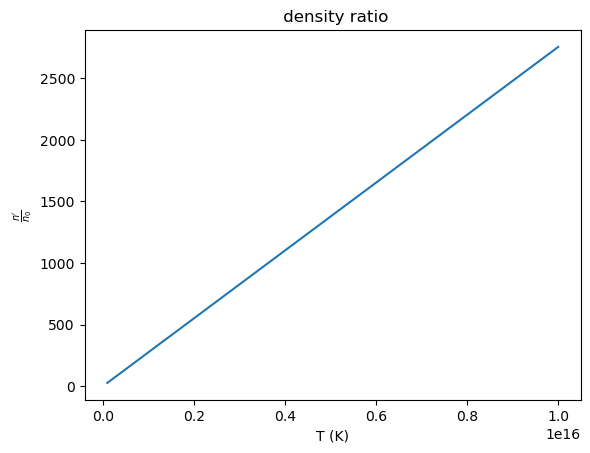

In [61]:
def n_prime(T):
    return ((gamma_chapeau_p(T)*gamma_maj(T) + 1)/gamma_chapeau_p(T) - 1)
plt.plot(T,n_prime(T))
plt.title(" density ratio")
plt.xlabel("T (K)")
plt.ylabel(r"$\frac{n'}{n_{0}} $")
plt.show()

Définition de la fonction $\frac{e_{i}}{n_{0}}'$ :

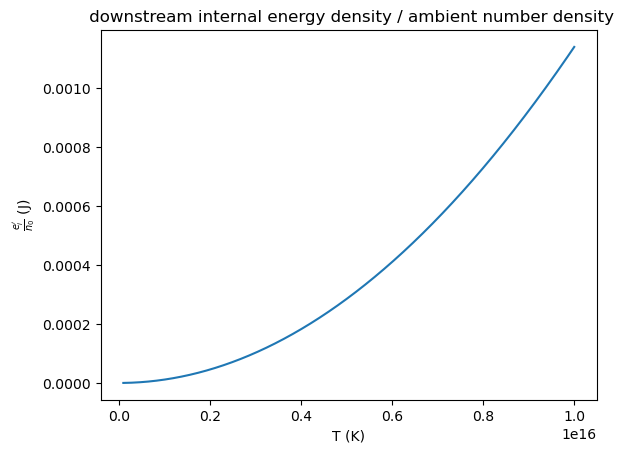

In [62]:
def e_i_p(T):
    return n_prime(T)*const.m_p*((scipy.constants.c)**2)*(gamma_maj(T)-1)

plt.plot(T,e_i_p(T))
plt.title(" downstream internal energy density / ambient number density")
plt.xlabel("T (K)")
plt.ylabel(r"$\frac{e_{i}'}{n_{0}}$ (J)")
plt.show()


In [ ]:
def gamma_prime_m(p):
    return np.maximum(1, (p - 2) / (p - 1) * const.m_p / const.m_e * epsilon_e *(gamma_maj -1))

def gamma_prime_c(epsilon_B, t):
    return (3 * const.m_e * const.c * gamma_maj) / (4 * const.sigma_T * epsilon_B * e_prime_i * t)

In [ ]:
def nu_prime_m(epsilon_B):
    return 3/16 * gamma_prime_m(p)**2 * const.q_e*B_prime(epsilon_B) / (const.m_e * const.c)
def nu_prime_c(epsilon_B, t):
    return 3/16 * gamma_prime_c(epsilon_B, t)**2 * const.q_e *B_prime(epsilon_B) / (const.m_e * const.c)

Pour la fonction d'émission qui est définie dans le papier par les équations (24) et (25) la renormalisation nous donne:

$$ x = \frac{\nu'}{\nu_{m}'}$$
Pour déterminer le régime de refroidissement on définit un rapport 
$$ \kappa = \frac{\nu_{c}'(\epsilon_{B},t)}{\nu_{m}'(\epsilon_{B})}$$
on obtient donc:
Si $\kappa > 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}}$  pour  $x <1$} \\
\text{$x^{-(p-1)/2}$ pour  $1\leq x \leq \kappa$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $\kappa < x$}
\end{cases}
\]

Si $\kappa \leq 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}} \kappa^{-1/3}$  pour  $x <\kappa$} \\
\text{$\kappa^{1/2} x^{-1/2}$ pour  $\kappa\leq x < 1$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $1  \leq x$}
\end{cases}
\]

In [4]:
#Pour la fonction d'émission on renormalise tout:
n0 = 1/np.power(10,3)
epsilon_e = 0.14
epsi_b_gaussianJ = 2.44*(1/np.power(10,4))
epsi_b_hollow_coneJ = 4.12*(1/np.power(10,5))
epsi_b_SpindleJ = 6.60*(1/np.power(10,4))
#pour l'instant en première approximation on prend p = 2.05
p = 2.05

def power_I(x,y):
    return 1/np.power(x,y)

#Rapport de comparaison pour les refroidissemts entre nu_prim_c et nu_prim_m
def Kappa(epsilon_B,t):
    return nu_prime_c(epsilon_B,t)/nu_prime_m(epsilon_B)

#Cas du Fasct-cooling
def FastcEmission(x, Kappa,p,epsilon_B,t):
    if x > Kappa(epsilon_B,t):
        return np.power(Kappa(epsilon_B,t),-1/3)*np.power(x,1/3)
    elif x >= Kappa(epsilon_B,t) and x <1:
        return np.power(Kappa(epsilon_B,t),1/2)*power_I(x,-1/2)
    else:
        power_I(Kappa(epsilon_B,t),-1/2)*power_I(x,-p/2)
#Cas du slow-cooling
def SlowcEmission(x,Kappa,p,epsilon_B,t):
    if x < 1:
        return np.power(x,1/3)
    elif x>=1 and x < Kappa(epsilon_B,t):
        return power_I(x,-(p-1)/2)
    else:
        return power_I(Kappa(epsilon_B,t),-1/2)*power_I(-p/2)

#Vectorisation des fonctions liées aux régimes de refroidissement
SlowcEmission_vect = np.vectorize(lambda x: SlowcEmission(x,Kappa,p,epsi_b_gaussianJ,n0,t))
FastcEmission_vect = np.vectorize(lambda x: FastcEmission(x, Kappa,p,epsi_b_gaussianJ,n0,t))


#Fonction d'émission
def Emission_function(Kappa,x,p,epsilon_B,t):
    if Kappa(epsilon_B,t) > 1:
        return SlowcEmission_vect(x)
    else:
        return FastcEmission_vect(x)

    
    
#Pour l'instant on fixe t = 10   
t = 10

In [5]:
x = np.linspace(0,10,5000)
y_H = Emission_function(Kappa,x,p,epsi_b_hollow_coneJ,t)
plt.plot(x,y_H)
plt.title("Emissivity function for hollow-cone jet")
plt.xlabel("x")
plt.ylabel("$\frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'}")
plt.show()

NameError: name 'nu_prime_c' is not defined

Groupe équation 31